# Summary plots showing antibody escape as line plots and mapped to RBD surface, averaged across groups.
This Python Jupyter notebook plots escape map line plots averaged across groups.

Also maps the group-average site-total escape to PDB 6M0J surface. 

## Imports and configuration
Import Python modules:

In [1]:
import os
import re

import collections

import Bio.PDB

import dms_variants.pdb_utils

from IPython.display import display, HTML

import math
import numpy as np

import pandas as pd
from plotnine import *

import yaml

Get configuration:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)
    
with open(config['lineplots_by_group_config']) as f:
    line_plot_config = yaml.safe_load(f)
    
results_dir = config['lineplots_by_group_dir']
os.makedirs(results_dir, exist_ok=True)

## Read escape fractions
Read the escape fractions for both the B.1.351 plasmas and the early 2020 plasmas, only keeping average of libraries:

In [3]:
escape_frac_types = config['escape_frac_files']
escape_frac_files = [config[f] for f in escape_frac_types]
site_metrics = {config[f]:config[f'{f[:-12]}site_metric'] for f in escape_frac_types}

escape_fracs_dfs = []

for f in escape_frac_files:
    
    site_metric = site_metrics[f]

    df = (pd.read_csv(f)
          .query('library == "average"')
          .drop(columns=['site', 'selection', 'library'])
          .rename(columns={'label_site': 'site',
                           site_metric: 'site_escape'
                          }
                 )
          [['condition', 'site', 'protein_chain', 'site_escape']]
         )
    escape_fracs_dfs.append(df)

escape_fracs=pd.concat(escape_fracs_dfs)

# make "padding" data frame covering all conditions, sites, and mutations
first_site = escape_fracs['site'].min()
last_site = escape_fracs['site'].max()

pad_df = pd.concat([pd.DataFrame({'condition': condition,
                                  'site': list(range(first_site, last_site + 1)),
                                 })
                    for condition in escape_fracs['condition'].unique()
                   ])

# pad escape fracs data frame
escape_fracs = (
    escape_fracs
    .merge(pad_df, how='outer')
    .fillna(0)
    .assign(protein_chain='E')
    )

escape_fracs.query('site_escape==361').head()

print('First few lines of escape-fraction data frame:')
display(HTML(escape_fracs.head().to_html(index=False)))

First few lines of escape-fraction data frame:


condition,site,protein_chain,site_escape
267C_repeat_200,331,E,0.05336
267C_repeat_200,331,E,0.05336
267C_repeat_200,331,E,0.05336
267C_repeat_200,331,E,0.05336
267C_repeat_200,331,E,0.05336


## Make group-averaged line plots

Saving to results/lineplots_by_group/primary_infections_grouped_lineplots.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/scales/scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/scales/scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.


Saving to results/lineplots_by_group/Delta_primary_v_breakthrough_grouped_lineplots.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/scales/scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.


Saving to results/lineplots_by_group/mRNAvax_comparelibs_grouped_lineplots.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/scales/scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.


Saving to results/lineplots_by_group/all_day30_grouped_lineplots.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


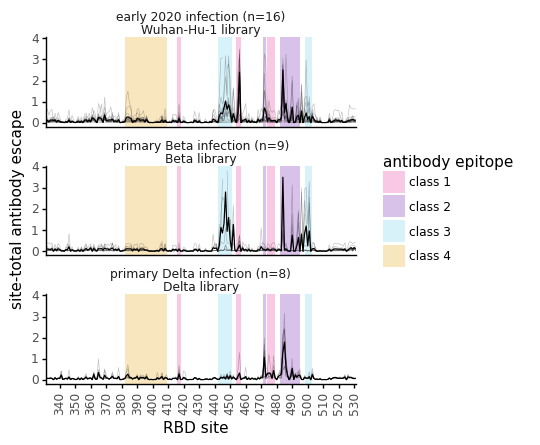

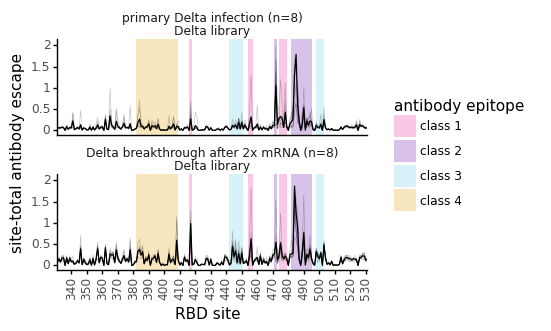

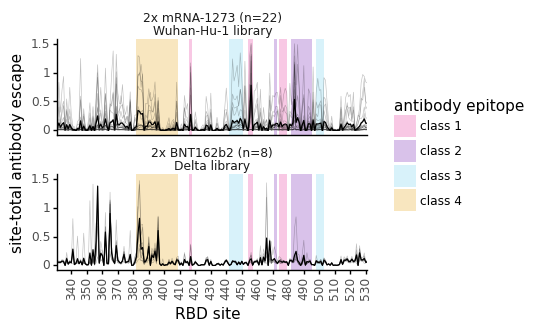

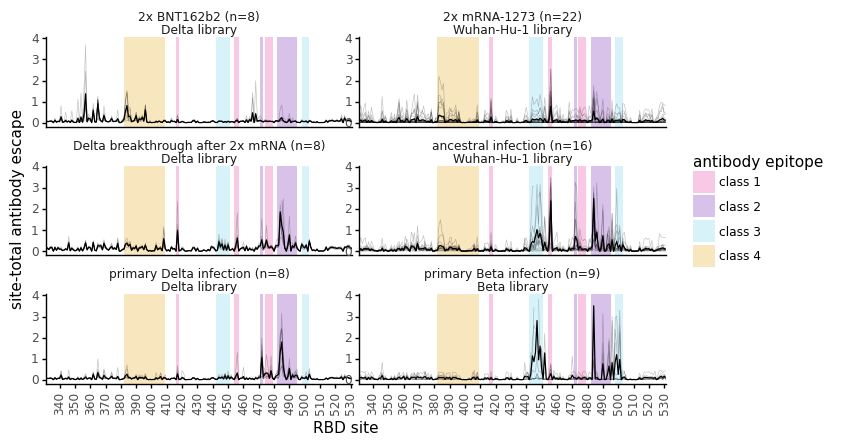

In [4]:
for supergroup, subgroup in line_plot_config.items():

    lineplot_df = pd.DataFrame()
    annotation_df = pd.DataFrame()

    for name, conditions in subgroup.items():
        
        assert set(conditions).issubset(set(escape_fracs['condition']))

        df = (escape_fracs
              .query('condition in @conditions')
              .assign(group_name=name,))
        
        lineplot_df = (pd.concat([lineplot_df,df], axis=0, ignore_index=True))

        label_df = (pd.DataFrame({'xmin': [382,482,454,442,416,471,474,498],
                                 'xmax': [409,495,457,451,418,473,479,503],
                                 'antibody_class': ['class 4', 'class 2', 'class 1', 'class 3', 'class 1','class 2','class 1','class 3'],
                                 'label': ['383-408','483-494','455-456','443-450','417','472','475-478','499-501'],
                                }
                               )
                    .assign(group_name=name,)
                   )
        annotation_df = pd.concat([annotation_df, label_df], axis=0, ignore_index=True)

    lineplot_df = (lineplot_df
        [['condition', 'site', 'site_escape', 'group_name']]
        .drop_duplicates()
        )

    # add mean in each group
    df_with_mean = (
        lineplot_df
        .append(lineplot_df.groupby(['group_name', 'site'], as_index=False)
                      .aggregate('mean')
                      .assign(condition='mean')
                )
        .assign(is_mean=lambda x: x['condition'] == 'mean')
        )

    annotation_df = (annotation_df
                     .assign(group_name=lambda x: pd.Categorical(x['group_name'], ordered=True,
                                                                 categories=subgroup.keys()
                                                                )
                            ) 
                    )

    # space breaks every ? sites
    site_break_freq = 10
    def get_site_breaks(tup):
        start = int(math.ceil(tup[0] / site_break_freq)) * site_break_freq
        end = int(math.floor(tup[1] / site_break_freq)) * site_break_freq
        return list(range(start, end + 1, site_break_freq))

    # make plot
    # have up to 5 plots in one column, otherwise split into 2 columns
    ncol=math.ceil(df_with_mean['group_name'].nunique()/5)
    nrow=math.ceil(df_with_mean['group_name'].nunique()/ncol)
    
    p = (ggplot(df_with_mean
                .assign(group_name=lambda x: pd.Categorical(x['group_name'], ordered=True,
                                                            categories=subgroup.keys()
                                                           )
                       )
               ) +
         aes('site', 'site_escape',
             group='condition',
             alpha='is_mean', size='is_mean') +

         geom_rect(data=annotation_df.assign(is_mean=False),
                   mapping=aes(xmin='xmin',
                               xmax='xmax',
                               ymin=-np.inf,
                               ymax=np.inf,
                               fill='antibody_class',
                              ),
                   alpha=0.25,
                   inherit_aes=False,
                  ) +

         geom_line() +
         facet_wrap('~ group_name', ncol=ncol, scales='free_y') +
         theme_classic() +
         theme(figure_size=(4*ncol, 1.5*nrow),
               axis_text_x=element_text(rotation=90, hjust=0.5),
               strip_background=element_blank(),
               ) +
         scale_x_continuous(expand=(0, 0), breaks=get_site_breaks) +
         scale_y_continuous(limits=(None, (df_with_mean.query('is_mean')['site_escape'].max()*1.1))) +
         scale_alpha_discrete(range=(0.25, 1)) +  # transparency of individual and mean lines
         scale_size_manual(values=(0.25, 0.5)) +  # size of individual and mean lines
         scale_color_manual(values=['#e52794', '#6a0dad', '#66ccee', '#E69F00']) +
         scale_fill_manual(values=['#e52794', '#6a0dad', '#66ccee', '#E69F00']) +
         guides(alpha=False, size=False, )+ #color=False, fill=False
         labs(x="RBD site",
              y="site-total antibody escape",
              color='antibody epitope',
              fill='antibody epitope',
             )
         ) 
        

    plotfile = f'{results_dir}/{supergroup}_grouped_lineplots.pdf'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

    _ = p.draw()

## Map the average site-total escape for a given antibody class or plasma/serum group to the RBD surface.

Outputs modified 6M0J PDBs with the escape scores as B factors.

Though we will want more elaborate series of commands to codify our visualization of these RBD structures colored by escape, the series of commands below, when executed in a PyMol session with one of these PDBs open, will color the RBD surface according to escape scores.

In [5]:
pdbfile = 'data/pdbs/6M0J.pdb'
assert os.path.isfile(pdbfile)
rbd_chain = config['escape_frac_protein_chain']
assert isinstance(rbd_chain, str)

# since we are plotting each group multiple times
# make sure we don't waste time replotting the same group repeatedly
plots_made = []

for supergroup, subgroup in line_plot_config.items():

    for name, conditions in subgroup.items():
        
        name=name.replace('.', '')
        name=name.replace(' ', '')
        name=re.search(r"^[^\(]*", name).group(0)
        
        if name not in plots_made:
            plots_made.append(name)

            print(f"\nMaking PDB mappings for the average of {len(conditions)} conditions for {name} to {pdbfile}")

            # get escape fracs just for conditions of interest
            df = escape_fracs.query('condition in @conditions')

            # assign average total_escape at each site across all the conditions in ab_class
            df = (df
                  .groupby(['site'])
                  .aggregate(mean_total_escape=pd.NamedAgg('site_escape', 'mean'),
                              )
                  .reset_index()
                  .drop_duplicates()
                 )

            # get chains
            print(f'Mapping to the following chain: {rbd_chain}')
            df = df.assign(chain=rbd_chain)


            # make mappings for each condition and metric
            print(f"  Writing B-factor re-assigned PDBs for {name} to:")

            for metric in ['mean_total_escape']: # keeping this as list because we might need to normalize

                # what do we assign to missing sites?
                missing_metric = collections.defaultdict(lambda: 0)  # non-RBD chains always fill to zero

                # note that the next line DOESN'T ACTUALLY WORK AS INTENDED because I'm using padded escape fracs
                missing_metric[rbd_chain] = -1  # missing sites in RBD are -1 for non-normalized metric PDBs

                fname = os.path.join(results_dir, f"{name}_6m0j_{metric}.pdb")
                print(f"    {fname}")

                dms_variants.pdb_utils.reassign_b_factor(input_pdbfile=pdbfile,
                                                         output_pdbfile=fname,
                                                         df=df,
                                                         metric_col=metric,
                                                         missing_metric=missing_metric)


Making PDB mappings for the average of 16 conditions for early2020infection to data/pdbs/6M0J.pdb
Mapping to the following chain: E
  Writing B-factor re-assigned PDBs for early2020infection to:
    results/lineplots_by_group/early2020infection_6m0j_mean_total_escape.pdb

Making PDB mappings for the average of 9 conditions for primaryBetainfection to data/pdbs/6M0J.pdb
Mapping to the following chain: E
  Writing B-factor re-assigned PDBs for primaryBetainfection to:
    results/lineplots_by_group/primaryBetainfection_6m0j_mean_total_escape.pdb

Making PDB mappings for the average of 8 conditions for primaryDeltainfection to data/pdbs/6M0J.pdb
Mapping to the following chain: E
  Writing B-factor re-assigned PDBs for primaryDeltainfection to:
    results/lineplots_by_group/primaryDeltainfection_6m0j_mean_total_escape.pdb

Making PDB mappings for the average of 8 conditions for Deltabreakthroughafter2xmRNA to data/pdbs/6M0J.pdb
Mapping to the following chain: E
  Writing B-factor re-assi